### Import required libraries

In [13]:
import os
import numpy as np
import matplotlib.pyplot as plt
import nibabel as nib
import torch
from torch import nn
from torch.utils.data import Dataset, DataLoader
import torchvision.transforms as transforms
import segmentation_models_pytorch as smp
import albumentations as A
from albumentations.pytorch import ToTensorV2
import cv2
from tqdm import tqdm
from collections import OrderedDict
import segmentation_models_pytorch as smp
import torch.optim as optim
from sklearn.model_selection import train_test_split

# --- Set data path ---
DATA_DIR = "/Users/afra/Desktop/MRNetSegmentation/MnM2/dataset"

# --- Set output images path ---
PLOT_DIR = "/Users/afra/Desktop/MRNetSegmentation/MnM2/plots"
os.makedirs(PLOT_DIR, exist_ok=True)

# --- Optional: set device ---
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# --- Print current device status ---
print(f"Using device: {device}")

Using device: cpu


### Load a NIfTI image (.nii.gz) and its ground truth and visualization

Image shape: (256, 256, 12)
Label shape: (256, 256, 12)


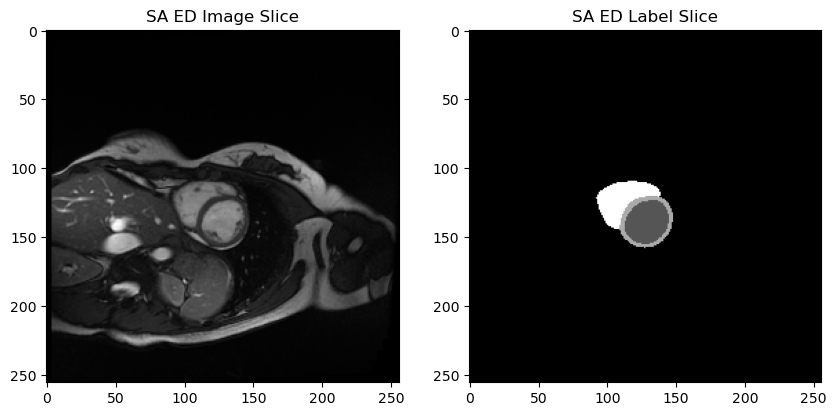

In [16]:
# Choose one subject folder
subject_folder = os.path.join(DATA_DIR, "001")

image_file = "001_SA_ED.nii.gz"
label_file = "001_SA_ED_gt.nii.gz"

# Load image and mask
img_nii = nib.load(os.path.join(subject_folder, image_file))
lbl_nii = nib.load(os.path.join(subject_folder, label_file))

img = img_nii.get_fdata()
lbl = lbl_nii.get_fdata()

print("Image shape:", img.shape)
print("Label shape:", lbl.shape)

# Display middle slice
slice_idx = img.shape[2] // 2
plt.figure(figsize=(10, 5))

plt.subplot(1, 2, 1)
plt.imshow(img[:, :, slice_idx], cmap='gray')
plt.title("SA ED Image Slice")

plt.subplot(1, 2, 2)
plt.imshow(lbl[:, :, slice_idx], cmap='gray')
plt.title("SA ED Label Slice")

plt.show()

### Define the MnM2Dataset class

In [19]:
class MnM2Dataset(Dataset):
    def __init__(self, root_dir, patient_ids, mode='ED', transform=None):
        """
        Args:
            root_dir (str): Path to dataset folder containing subject folders.
            patient_ids (list): List of subject IDs to include, e.g., ['001', '002']
            mode (str): 'ED' or 'ES' time point.
            transform (callable, optional): Optional transform to be applied on a sample.
        """
        self.root_dir = root_dir
        self.patient_ids = patient_ids
        self.mode = mode
        self.transform = transform
        self.samples = []

        for pid in self.patient_ids:
            image_path = os.path.join(root_dir, pid, f"{pid}_SA_{mode}.nii.gz")
            label_path = os.path.join(root_dir, pid, f"{pid}_SA_{mode}_gt.nii.gz")
            if os.path.exists(image_path) and os.path.exists(label_path):
                img = nib.load(image_path).get_fdata()
                lbl = nib.load(label_path).get_fdata()
                for i in range(img.shape[2]):
                    self.samples.append((img[:, :, i], lbl[:, :, i]))

    def __len__(self):
        return len(self.samples)

    def __getitem__(self, idx):
        img_slice, lbl_slice = self.samples[idx]

        # Normalize image to [0, 1]
        img_slice = (img_slice - np.min(img_slice)) / (np.max(img_slice) - np.min(img_slice) + 1e-8)

        # Resize image and label to 256x256
        img_slice = cv2.resize(img_slice, (256, 256), interpolation=cv2.INTER_LINEAR)
        lbl_slice = cv2.resize(lbl_slice, (256, 256), interpolation=cv2.INTER_NEAREST)

        # Map label values to class indices
        lbl_slice = np.where(lbl_slice == 500, 1, lbl_slice)
        lbl_slice = np.where(lbl_slice == 600, 2, lbl_slice)
        lbl_slice = np.where((lbl_slice != 0) & (lbl_slice != 1) & (lbl_slice != 2), 0, lbl_slice)

        # Expand image channel to [1, 256, 256]
        img_slice = np.expand_dims(img_slice, axis=0)

        # Print unique values
        #print("Unique label values in this sample:", np.unique(lbl_slice))

        return {
            'image': torch.tensor(img_slice, dtype=torch.float32),
            'mask': torch.tensor(lbl_slice, dtype=torch.long)
    }

### Create Dataset and DataLoader

In [22]:
# Define patient IDs
all_patients = sorted(os.listdir(DATA_DIR))

# Training 80% and validation 20%
train_ids, val_ids = train_test_split(all_patients, test_size=0.2, random_state=2025)

# Create dataset
train_dataset = MnM2Dataset(DATA_DIR, train_ids, mode='ED')
val_dataset = MnM2Dataset(DATA_DIR, val_ids, mode='ED')

# Create DataLoader
train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=8, shuffle=True)
val_loader = torch.utils.data.DataLoader(val_dataset, batch_size=8, shuffle=False)

# Check one sample
sample = next(iter(train_loader))
print("Image shape:", sample['image'].shape)  # [8, 1, 256, 256]
print("Mask shape:", sample['mask'].shape)    # [8, 256, 256]

Image shape: torch.Size([8, 1, 256, 256])
Mask shape: torch.Size([8, 256, 256])


### Define the U-Net model structure - U-Net

In [24]:
class UNet(nn.Module):
    def __init__(self, in_channels=1, out_channels=4, init_features=32):
        super(UNet, self).__init__()

        features = init_features

        self.encoder1 = UNet._block(in_channels, features, name="enc1")
        self.pool1 = nn.MaxPool2d(kernel_size=2, stride=2)
        self.encoder2 = UNet._block(features, features * 2, name="enc2")
        self.pool2 = nn.MaxPool2d(kernel_size=2, stride=2)
        self.encoder3 = UNet._block(features * 2, features * 4, name="enc3")
        self.pool3 = nn.MaxPool2d(kernel_size=2, stride=2)
        self.encoder4 = UNet._block(features * 4, features * 8, name="enc4")
        self.pool4 = nn.MaxPool2d(kernel_size=2, stride=2)

        self.bottleneck = UNet._block(features * 8, features * 16, name="bottleneck")

        self.upconv4 = nn.ConvTranspose2d(
            features * 16, features * 8, kernel_size=2, stride=2
        )
        self.decoder4 = UNet._block((features * 8) * 2, features * 8, name="dec4")
        self.upconv3 = nn.ConvTranspose2d(
            features * 8, features * 4, kernel_size=2, stride=2
        )
        self.decoder3 = UNet._block((features * 4) * 2, features * 4, name="dec3")
        self.upconv2 = nn.ConvTranspose2d(
            features * 4, features * 2, kernel_size=2, stride=2
        )
        self.decoder2 = UNet._block((features * 2) * 2, features * 2, name="dec2")
        self.upconv1 = nn.ConvTranspose2d(
            features * 2, features, kernel_size=2, stride=2
        )
        self.decoder1 = UNet._block(features * 2, features, name="dec1")

        self.conv = nn.Conv2d(
            in_channels=features, out_channels=out_channels, kernel_size=1
        )

    def forward(self, x):
        enc1 = self.encoder1(x)
        enc2 = self.encoder2(self.pool1(enc1))
        enc3 = self.encoder3(self.pool2(enc2))
        enc4 = self.encoder4(self.pool3(enc3))

        bottleneck = self.bottleneck(self.pool4(enc4))

        dec4 = self.upconv4(bottleneck)
        dec4 = torch.cat((dec4, enc4), dim=1)
        dec4 = self.decoder4(dec4)
        dec3 = self.upconv3(dec4)
        dec3 = torch.cat((dec3, enc3), dim=1)
        dec3 = self.decoder3(dec3)
        dec2 = self.upconv2(dec3)
        dec2 = torch.cat((dec2, enc2), dim=1)
        dec2 = self.decoder2(dec2)
        dec1 = self.upconv1(dec2)
        dec1 = torch.cat((dec1, enc1), dim=1)
        dec1 = self.decoder1(dec1)

        out = self.conv(dec1)

        return out

    @staticmethod
    def _block(in_channels, features, name):
        return nn.Sequential(
            OrderedDict(
                [
                    (
                        name + "conv1",
                        nn.Conv2d(
                            in_channels=in_channels,
                            out_channels=features,
                            kernel_size=3,
                            padding=1,
                            bias=False,
                        ),
                    ),
                    (name + "norm1", nn.BatchNorm2d(num_features=features)),
                    (name + "relu1", nn.ReLU(inplace=True)),

                    (
                        name + "conv2",
                        nn.Conv2d(
                            in_channels=features,
                            out_channels=features,
                            kernel_size=3,
                            padding=1,
                            bias=False,
                        ),
                    ),
                    (name + "norm2", nn.BatchNorm2d(num_features=features)),
                    (name + "relu2", nn.ReLU(inplace=True))

                ]
            )
        )

In [27]:
# ========== utility function ==========
def dice_score(preds, targets, num_classes=3):
    dice = 0
    preds = torch.argmax(preds, dim=1)
    for cls in range(num_classes):
        pred_cls = (preds == cls).float()
        target_cls = (targets == cls).float()
        intersection = (pred_cls * target_cls).sum()
        union = pred_cls.sum() + target_cls.sum()
        dice += 2. * intersection / (union + 1e-6) if union > 0 else 1
    return dice / num_classes

def iou_score(preds, targets, num_classes=3):
    iou = 0
    preds = torch.argmax(preds, dim=1)
    for cls in range(num_classes):
        pred_cls = (preds == cls).float()
        target_cls = (targets == cls).float()
        intersection = (pred_cls * target_cls).sum()
        union = pred_cls.sum() + target_cls.sum() - intersection
        iou += intersection / (union + 1e-6) if union > 0 else 1
    return iou / num_classes

def plot_metrics(metrics, filename=os.path.join(PLOT_DIR, 'training_curves.png')):
    plt.figure(figsize=(10, 6))
    for key in metrics:
        plt.plot(metrics[key], label=key)
    plt.xlabel('Epoch')
    plt.ylabel('Score')
    plt.legend()
    plt.title('Training Metrics over Epochs')
    plt.savefig(filename, dpi=300)
    plt.close()

def visualize_predictions_grid(images, preds, masks, save_path="grid_prediction.png", num_samples=4):
    preds = torch.argmax(preds, dim=1)
    images = images.cpu().numpy()
    preds = preds.cpu().numpy()
    masks = masks.cpu().numpy()

    num_samples = min(num_samples, images.shape[0])

    fig, axes = plt.subplots(num_samples, 3, figsize=(12, 4 * num_samples))
    for i in range(num_samples):
        axes[i, 0].imshow(images[i][0], cmap='gray')
        axes[i, 0].set_title("Image")
        axes[i, 1].imshow(masks[i])
        axes[i, 1].set_title("Ground Truth")
        axes[i, 2].imshow(preds[i])
        axes[i, 2].set_title("Prediction")
        for j in range(3):
            axes[i, j].axis('off')
    plt.tight_layout()
    plt.savefig(save_path)
    plt.close()

In [29]:
class GradCAM:
    def __init__(self, model, target_layer):
        self.model = model
        self.target_layer = target_layer
        self.gradients = None
        self.activations = None
        self._register_hooks()

    def _register_hooks(self):
        def forward_hook(module, input, output):
            self.activations = output.detach()
        def backward_hook(module, grad_in, grad_out):
            self.gradients = grad_out[0].detach()
        self.target_layer.register_forward_hook(forward_hook)
        self.target_layer.register_backward_hook(backward_hook)

    def generate(self, input_tensor, class_idx):
        self.model.zero_grad()
        output = self.model(input_tensor)
        class_score = output[:, class_idx, :, :].sum()
        class_score.backward()
        weights = self.gradients.mean(dim=(2, 3), keepdim=True)
        cam = (weights * self.activations).sum(dim=1)
        cam = torch.relu(cam)
        cam = cam - cam.min()
        cam = cam / (cam.max() + 1e-8)
        cam = torch.nn.functional.interpolate(cam.unsqueeze(1), size=input_tensor.shape[2:], mode='bilinear', align_corners=False)
        return cam.squeeze().cpu().numpy()

In [31]:
# ========== Main ==========
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# UNet Model
model = UNet(in_channels=1, out_channels=3).to(device)

criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=1e-4)
epochs = 30
best_dice = 0.0

history = {
    'train_loss': [], 'val_loss': [],
    'train_dice': [], 'val_dice': [],
    'val_iou': []
}

for epoch in range(epochs):
    model.train()
    train_loss, train_dice = 0, 0

    for batch in tqdm(train_loader, desc=f"Epoch {epoch+1}/{epochs} - Training"):
        images = batch['image'].to(device)
        masks = batch['mask'].to(device)

        outputs = model(images)
        loss = criterion(outputs, masks)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        train_loss += loss.item()
        train_dice += dice_score(outputs, masks).item()

    train_loss /= len(train_loader)
    train_dice /= len(train_loader)

    model.eval()
    val_loss, val_dice, val_iou = 0, 0, 0
    with torch.no_grad():
        for batch in tqdm(val_loader, desc=f"Epoch {epoch+1}/{epochs} - Validation"):
            images = batch['image'].to(device)
            masks = batch['mask'].to(device)

            outputs = model(images)
            loss = criterion(outputs, masks)

            val_loss += loss.item()
            val_dice += dice_score(outputs, masks).item()
            val_iou += iou_score(outputs, masks).item()

    val_loss /= len(val_loader)
    val_dice /= len(val_loader)
    val_iou /= len(val_loader)

    print(f"\n📊 Epoch {epoch+1} Summary:")
    print(f"Train Loss: {train_loss:.4f} | Dice: {train_dice:.4f}")
    print(f"Val   Loss: {val_loss:.4f} | Dice: {val_dice:.4f} | IoU: {val_iou:.4f}")

    history['train_loss'].append(train_loss)
    history['val_loss'].append(val_loss)
    history['train_dice'].append(train_dice)
    history['val_dice'].append(val_dice)
    history['val_iou'].append(val_iou)

    if val_dice > best_dice:
        best_dice = val_dice
        torch.save(model.state_dict(), "best_model.pth")
        print("✅ Best model saved!")

    # Visualize predictions
    visualize_predictions_grid(images, outputs, masks, save_path=os.path.join(PLOT_DIR, f"epoch_{epoch+1}_prediction.png"), num_samples=4)

    # Grad-CAM: use model.bottleneck
    gradcam = GradCAM(model, target_layer=model.bottleneck)

    if images.shape[0] > 0:
        test_image = images[0].unsqueeze(0).to(device)
        cam = gradcam.generate(test_image, class_idx=1)

        orig_img = test_image[0][0].detach().cpu().numpy()
        orig_img = (orig_img - orig_img.min()) / (orig_img.max() - orig_img.min() + 1e-8)
        orig_img_rgb = np.stack([orig_img]*3, axis=-1)

        cam_resized = cv2.resize(cam, (256, 256))
        heatmap = cv2.applyColorMap(np.uint8(255 * cam_resized), cv2.COLORMAP_JET)
        heatmap = cv2.cvtColor(heatmap, cv2.COLOR_BGR2RGB) / 255.0
        overlay = np.clip(heatmap * 0.4 + orig_img_rgb * 0.6, 0, 1)

        fig, axs = plt.subplots(1, 3, figsize=(12, 4))
        axs[0].imshow(orig_img_rgb)
        axs[0].set_title("Original Image")
        axs[1].imshow(cam_resized, cmap='jet')
        axs[1].set_title("Grad-CAM (class 1)")
        axs[2].imshow(overlay)
        axs[2].set_title("Overlay")
        for ax in axs: ax.axis('off')
        plt.tight_layout()
        plt.savefig(os.path.join(PLOT_DIR, f"gradcam_epoch{epoch+1}.png"), dpi=300)
        plt.close()

plot_metrics(history, filename=os.path.join(PLOT_DIR, "training_curves.png"))

Epoch 1/30 - Validation: 100%|██████████| 101/101 [01:38<00:00,  1.03it/s]



📊 Epoch 1 Summary:
Train Loss: 0.7163 | Dice: 0.4160
Val   Loss: 0.4679 | Dice: 0.4989 | IoU: 0.4531
✅ Best model saved!


/opt/anaconda3/lib/python3.12/site-packages/torch/nn/modules/module.py:1830: FutureWarning: Using a non-full backward hook when the forward contains multiple autograd Nodes is deprecated and will be removed in future versions. This hook will be missing some grad_input. Please use register_full_backward_hook to get the documented behavior.
  self._maybe_warn_non_full_backward_hook(args, result, grad_fn)
Epoch 2/30 - Validation: 100%|██████████| 101/101 [01:38<00:00,  1.03it/s]



📊 Epoch 2 Summary:
Train Loss: 0.3331 | Dice: 0.7792
Val   Loss: 0.2331 | Dice: 0.8342 | IoU: 0.7539
✅ Best model saved!


Epoch 3/30 - Validation: 100%|██████████| 101/101 [01:38<00:00,  1.02it/s]



📊 Epoch 3 Summary:
Train Loss: 0.1683 | Dice: 0.8699
Val   Loss: 0.1226 | Dice: 0.8658 | IoU: 0.7914
✅ Best model saved!


Epoch 4/30 - Validation: 100%|██████████| 101/101 [01:38<00:00,  1.03it/s]



📊 Epoch 4 Summary:
Train Loss: 0.0962 | Dice: 0.8944
Val   Loss: 0.0775 | Dice: 0.8779 | IoU: 0.8060
✅ Best model saved!


Epoch 5/30 - Validation: 100%|██████████| 101/101 [01:21<00:00,  1.24it/s]



📊 Epoch 5 Summary:
Train Loss: 0.0615 | Dice: 0.9066
Val   Loss: 0.0516 | Dice: 0.8956 | IoU: 0.8272
✅ Best model saved!


Epoch 6/30 - Validation: 100%|██████████| 101/101 [01:21<00:00,  1.24it/s]



📊 Epoch 6 Summary:
Train Loss: 0.0423 | Dice: 0.9147
Val   Loss: 0.0363 | Dice: 0.9046 | IoU: 0.8402
✅ Best model saved!


Epoch 7/30 - Validation: 100%|██████████| 101/101 [01:21<00:00,  1.24it/s]



📊 Epoch 7 Summary:
Train Loss: 0.0306 | Dice: 0.9196
Val   Loss: 0.0292 | Dice: 0.9006 | IoU: 0.8353


Epoch 8/30 - Validation: 100%|██████████| 101/101 [01:21<00:00,  1.24it/s]



📊 Epoch 8 Summary:
Train Loss: 0.0234 | Dice: 0.9235
Val   Loss: 0.0285 | Dice: 0.9044 | IoU: 0.8402


Epoch 9/30 - Validation: 100%|██████████| 101/101 [01:21<00:00,  1.24it/s]



📊 Epoch 9 Summary:
Train Loss: 0.0193 | Dice: 0.9237
Val   Loss: 0.0199 | Dice: 0.9063 | IoU: 0.8439
✅ Best model saved!


Epoch 10/30 - Validation: 100%|██████████| 101/101 [01:21<00:00,  1.25it/s]



📊 Epoch 10 Summary:
Train Loss: 0.0154 | Dice: 0.9299
Val   Loss: 0.0186 | Dice: 0.9092 | IoU: 0.8473
✅ Best model saved!


Epoch 11/30 - Validation: 100%|██████████| 101/101 [01:21<00:00,  1.24it/s]



📊 Epoch 11 Summary:
Train Loss: 0.0133 | Dice: 0.9318
Val   Loss: 0.0161 | Dice: 0.9139 | IoU: 0.8539
✅ Best model saved!


Epoch 12/30 - Validation: 100%|██████████| 101/101 [01:21<00:00,  1.24it/s]



📊 Epoch 12 Summary:
Train Loss: 0.0118 | Dice: 0.9328
Val   Loss: 0.0146 | Dice: 0.9174 | IoU: 0.8588
✅ Best model saved!


Epoch 13/30 - Validation: 100%|██████████| 101/101 [01:21<00:00,  1.24it/s]



📊 Epoch 13 Summary:
Train Loss: 0.0099 | Dice: 0.9393
Val   Loss: 0.0137 | Dice: 0.9153 | IoU: 0.8559


Epoch 14/30 - Validation: 100%|██████████| 101/101 [01:21<00:00,  1.24it/s]



📊 Epoch 14 Summary:
Train Loss: 0.0088 | Dice: 0.9414
Val   Loss: 0.0133 | Dice: 0.9201 | IoU: 0.8626
✅ Best model saved!


Epoch 15/30 - Validation: 100%|██████████| 101/101 [01:39<00:00,  1.01it/s]



📊 Epoch 15 Summary:
Train Loss: 0.0085 | Dice: 0.9406
Val   Loss: 0.0125 | Dice: 0.9194 | IoU: 0.8618


Epoch 16/30 - Validation: 100%|██████████| 101/101 [01:38<00:00,  1.03it/s]



📊 Epoch 16 Summary:
Train Loss: 0.0074 | Dice: 0.9451
Val   Loss: 0.0136 | Dice: 0.9175 | IoU: 0.8592


Epoch 17/30 - Validation: 100%|██████████| 101/101 [01:38<00:00,  1.03it/s]



📊 Epoch 17 Summary:
Train Loss: 0.0090 | Dice: 0.9350
Val   Loss: 0.0126 | Dice: 0.9122 | IoU: 0.8506


Epoch 18/30 - Validation: 100%|██████████| 101/101 [01:39<00:00,  1.02it/s]



📊 Epoch 18 Summary:
Train Loss: 0.0074 | Dice: 0.9425
Val   Loss: 0.0144 | Dice: 0.9113 | IoU: 0.8493


Epoch 19/30 - Validation: 100%|██████████| 101/101 [01:39<00:00,  1.02it/s]



📊 Epoch 19 Summary:
Train Loss: 0.0073 | Dice: 0.9414
Val   Loss: 0.0130 | Dice: 0.9091 | IoU: 0.8467


Epoch 20/30 - Validation: 100%|██████████| 101/101 [01:40<00:00,  1.01it/s]



📊 Epoch 20 Summary:
Train Loss: 0.0067 | Dice: 0.9446
Val   Loss: 0.0152 | Dice: 0.8998 | IoU: 0.8336


Epoch 21/30 - Validation: 100%|██████████| 101/101 [01:39<00:00,  1.01it/s]



📊 Epoch 21 Summary:
Train Loss: 0.0068 | Dice: 0.9432
Val   Loss: 0.0141 | Dice: 0.9099 | IoU: 0.8481


Epoch 22/30 - Validation: 100%|██████████| 101/101 [01:22<00:00,  1.23it/s]



📊 Epoch 22 Summary:
Train Loss: 0.0055 | Dice: 0.9521
Val   Loss: 0.0117 | Dice: 0.9224 | IoU: 0.8665
✅ Best model saved!


Epoch 23/30 - Validation: 100%|██████████| 101/101 [01:22<00:00,  1.22it/s]



📊 Epoch 23 Summary:
Train Loss: 0.0052 | Dice: 0.9535
Val   Loss: 0.0117 | Dice: 0.9219 | IoU: 0.8659


Epoch 24/30 - Validation: 100%|██████████| 101/101 [01:23<00:00,  1.22it/s]



📊 Epoch 24 Summary:
Train Loss: 0.0056 | Dice: 0.9514
Val   Loss: 0.0114 | Dice: 0.9231 | IoU: 0.8675
✅ Best model saved!


Epoch 25/30 - Validation: 100%|██████████| 101/101 [01:23<00:00,  1.21it/s]



📊 Epoch 25 Summary:
Train Loss: 0.0051 | Dice: 0.9534
Val   Loss: 0.0120 | Dice: 0.9237 | IoU: 0.8684
✅ Best model saved!


Epoch 26/30 - Validation: 100%|██████████| 101/101 [01:21<00:00,  1.24it/s]



📊 Epoch 26 Summary:
Train Loss: 0.0050 | Dice: 0.9543
Val   Loss: 0.0144 | Dice: 0.9207 | IoU: 0.8640


Epoch 27/30 - Validation: 100%|██████████| 101/101 [01:21<00:00,  1.24it/s]



📊 Epoch 27 Summary:
Train Loss: 0.0054 | Dice: 0.9522
Val   Loss: 0.0156 | Dice: 0.9073 | IoU: 0.8434


Epoch 28/30 - Validation: 100%|██████████| 101/101 [01:21<00:00,  1.24it/s]



📊 Epoch 28 Summary:
Train Loss: 0.0061 | Dice: 0.9474
Val   Loss: 0.0122 | Dice: 0.9200 | IoU: 0.8631


Epoch 29/30 - Validation: 100%|██████████| 101/101 [01:21<00:00,  1.24it/s]



📊 Epoch 29 Summary:
Train Loss: 0.0046 | Dice: 0.9575
Val   Loss: 0.0127 | Dice: 0.9228 | IoU: 0.8674


Epoch 30/30 - Validation: 100%|██████████| 101/101 [01:21<00:00,  1.24it/s]



📊 Epoch 30 Summary:
Train Loss: 0.0041 | Dice: 0.9615
Val   Loss: 0.0135 | Dice: 0.9228 | IoU: 0.8679


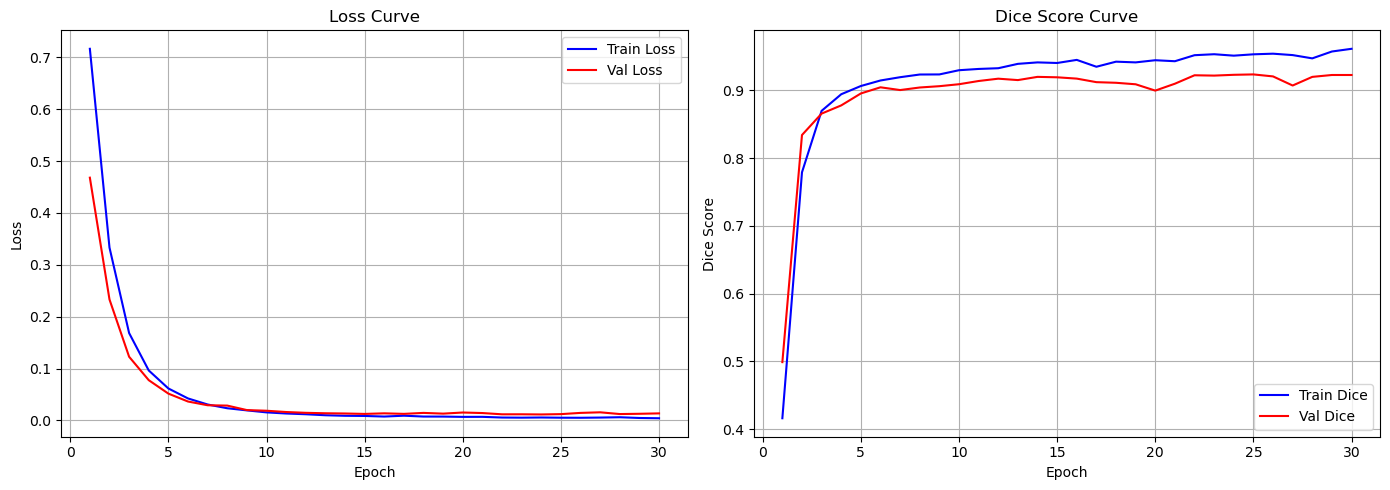

In [33]:
def plot_loss_dice(history, save_path="training_curves.png"):
    epochs = range(1, len(history['train_loss']) + 1)

    fig, axs = plt.subplots(1, 2, figsize=(14, 5))

    # ---- Left: Loss Curve ----
    axs[0].plot(epochs, history['train_loss'], label='Train Loss', color='blue')
    axs[0].plot(epochs, history['val_loss'], label='Val Loss', color='red')
    axs[0].set_title('Loss Curve')
    axs[0].set_xlabel('Epoch')
    axs[0].set_ylabel('Loss')
    axs[0].legend()
    axs[0].grid(True)

    # ---- Right: Dice Curve ----
    axs[1].plot(epochs, history['train_dice'], label='Train Dice', color='blue')
    axs[1].plot(epochs, history['val_dice'], label='Val Dice', color='red')
    axs[1].set_title('Dice Score Curve')
    axs[1].set_xlabel('Epoch')
    axs[1].set_ylabel('Dice Score')
    axs[1].legend()
    axs[1].grid(True)

    plt.tight_layout()
    plt.savefig(save_path, dpi=300)
    plt.show()

plot_loss_dice(history, save_path=os.path.join(PLOT_DIR, "loss_dice_curves.png"))

In [53]:
best_epoch = history['val_dice'].index(max(history['val_dice'])) + 1
best_val_dice = history['val_dice'][best_epoch - 1]
best_val_loss = history['val_loss'][best_epoch - 1]
best_val_iou  = history['val_iou'][best_epoch - 1]

print("\n✅ Best Model (on Validation Set):")
print(f"Best Epoch     : {best_epoch}")
print(f"Val Dice       : {best_val_dice:.4f}")
print(f"Val IoU        : {best_val_iou:.4f}")
print(f"Val Loss       : {best_val_loss:.4f}")


✅ Best Model (on Validation Set):
Best Epoch     : 25
Val Dice       : 0.9237
Val IoU        : 0.8684
Val Loss       : 0.0120


Grad-CAM for Epoch 5


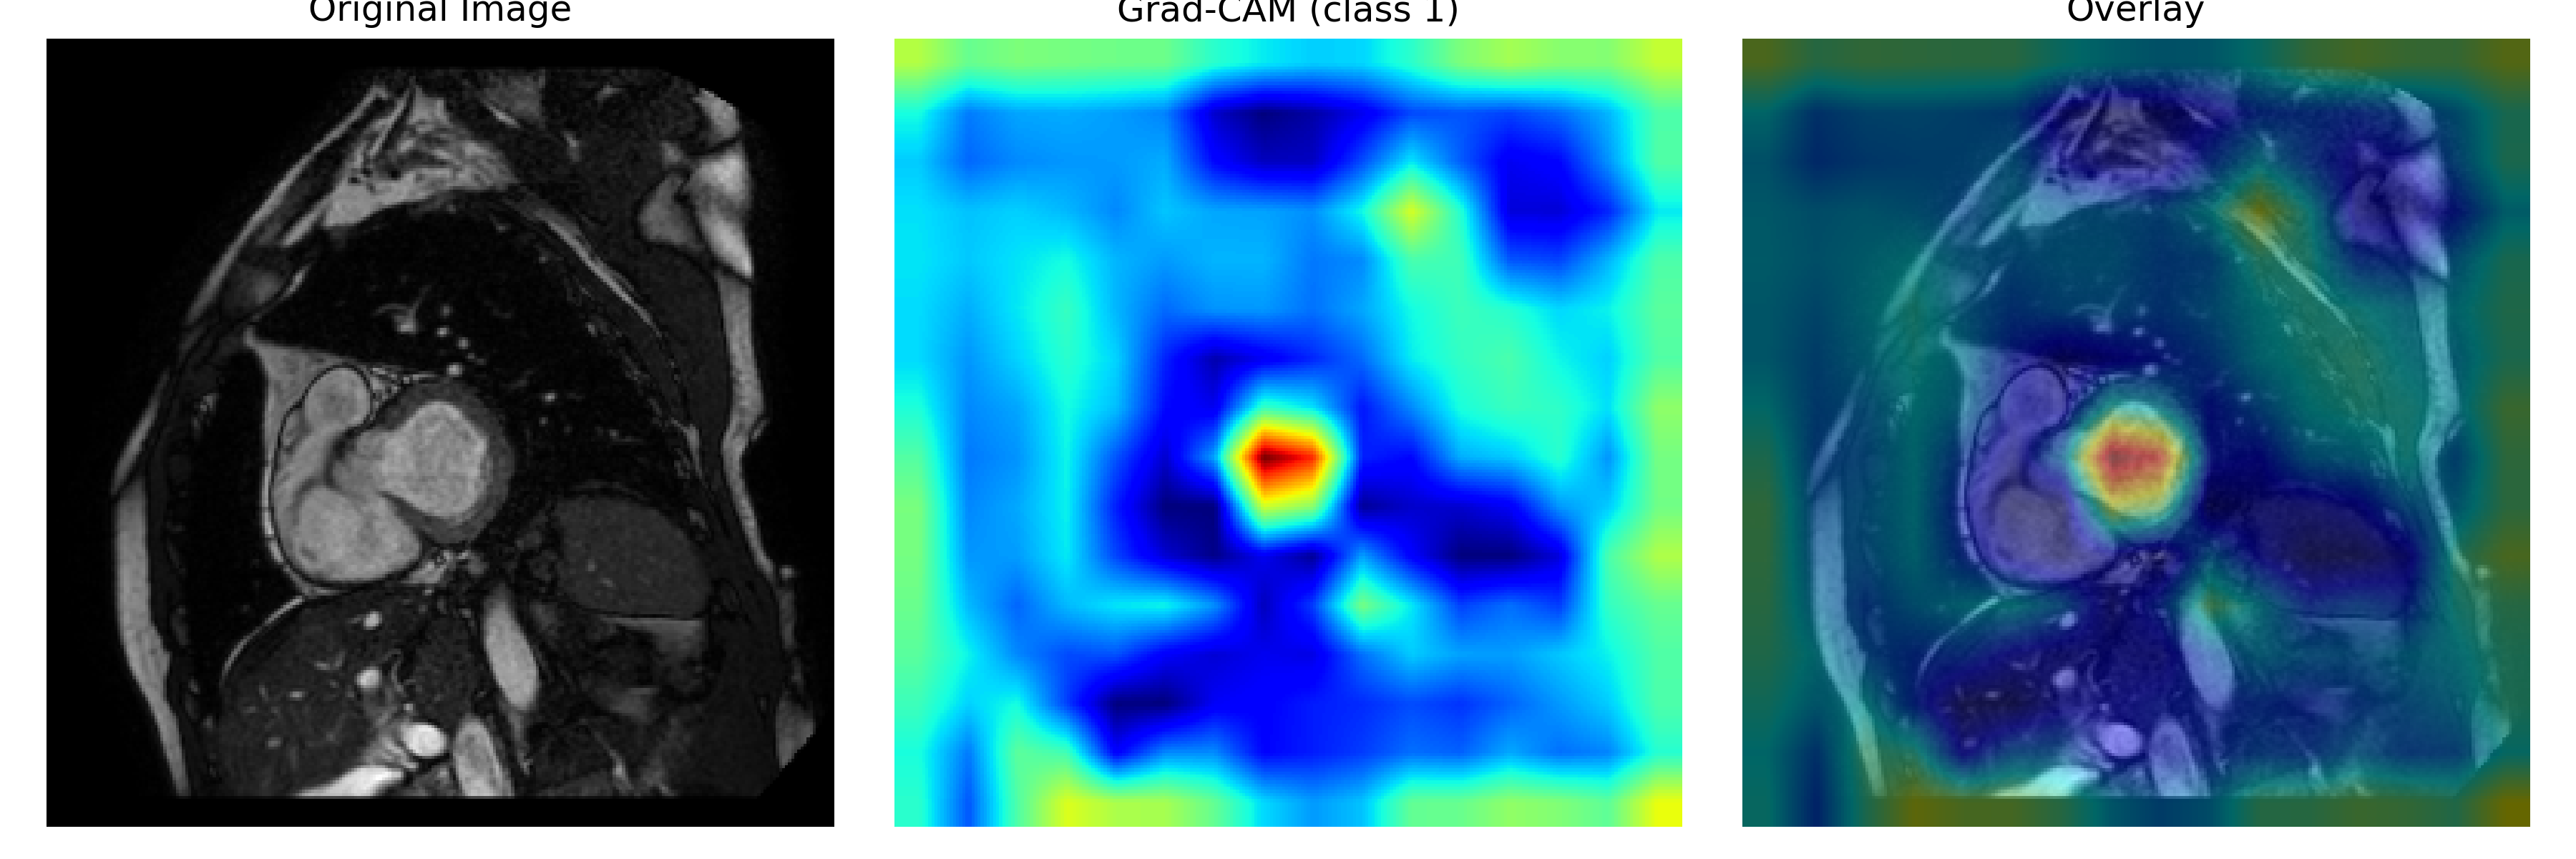

Grad-CAM for Epoch 10


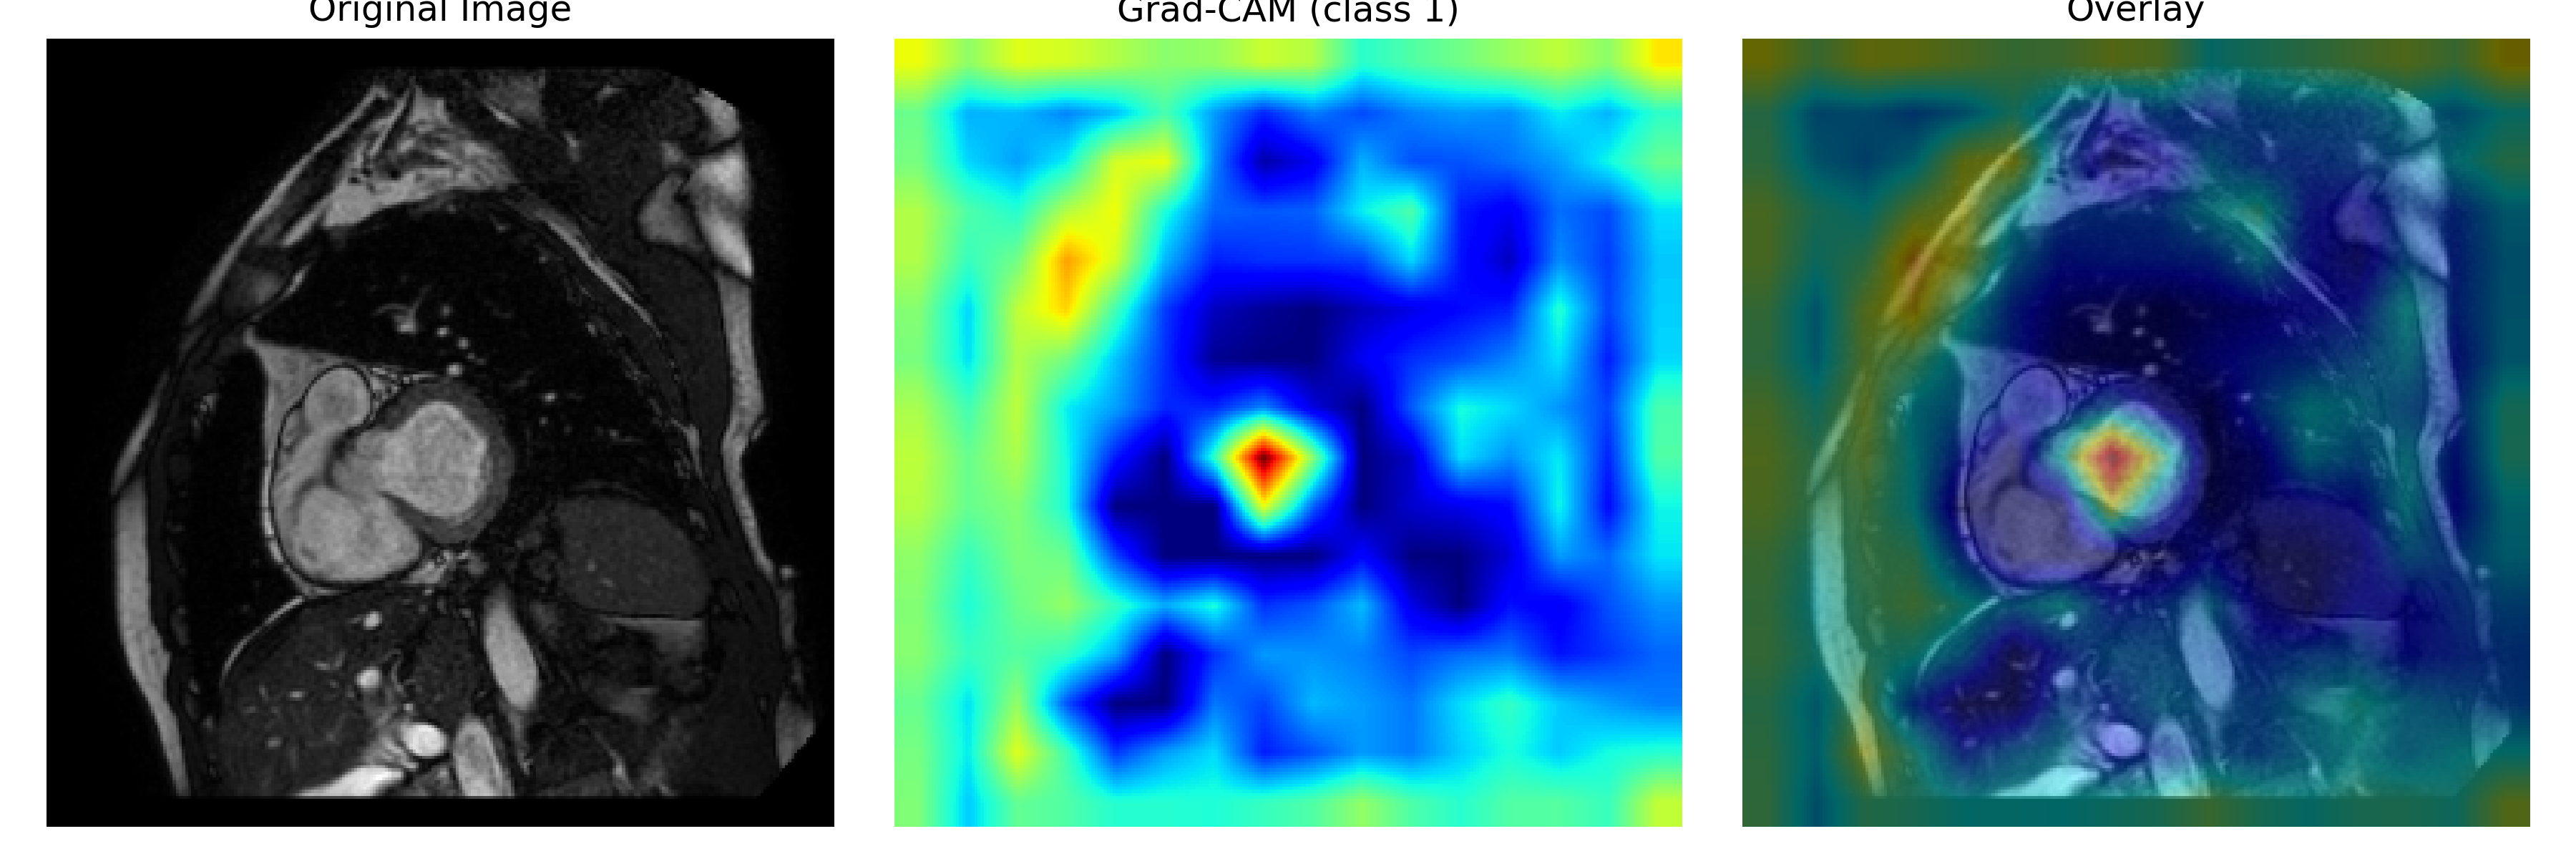

Grad-CAM for Epoch 20


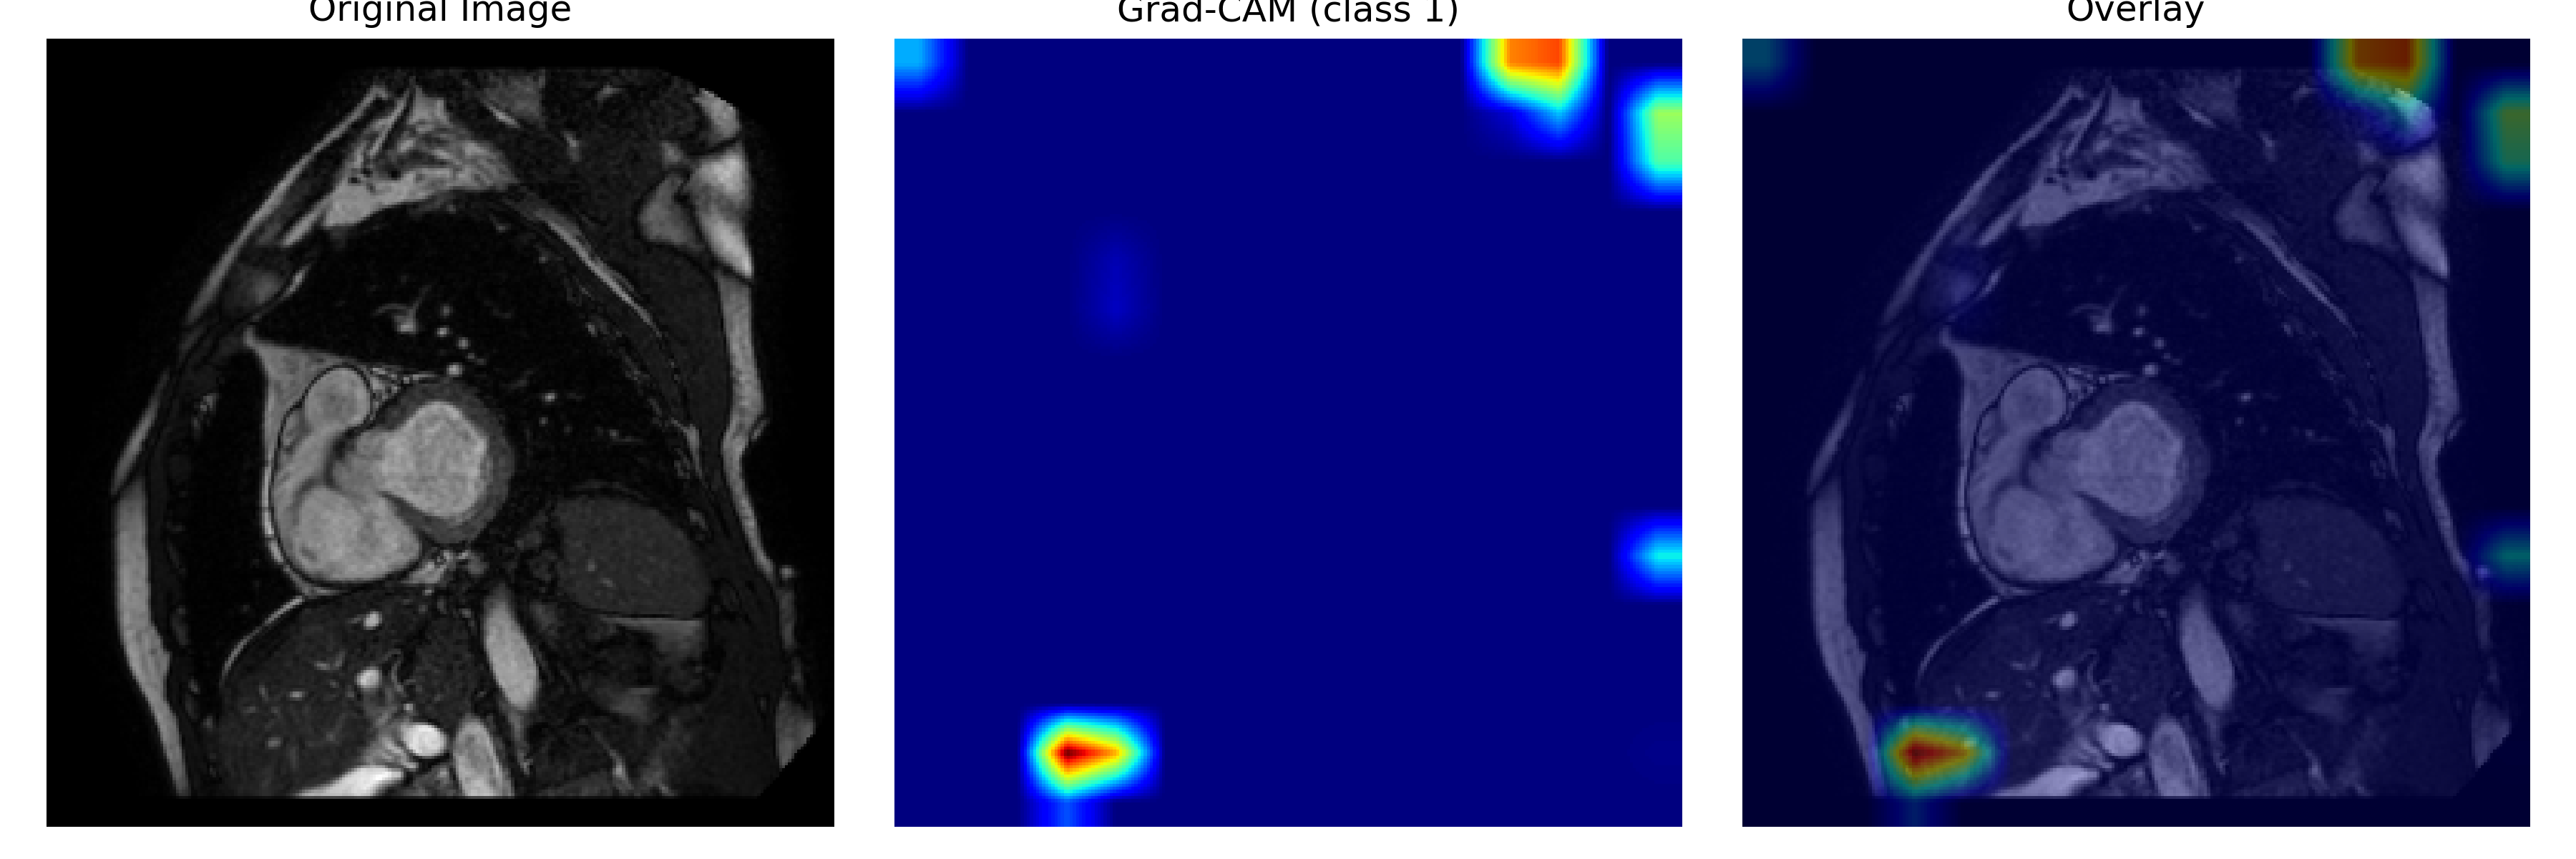

Grad-CAM for Epoch 25


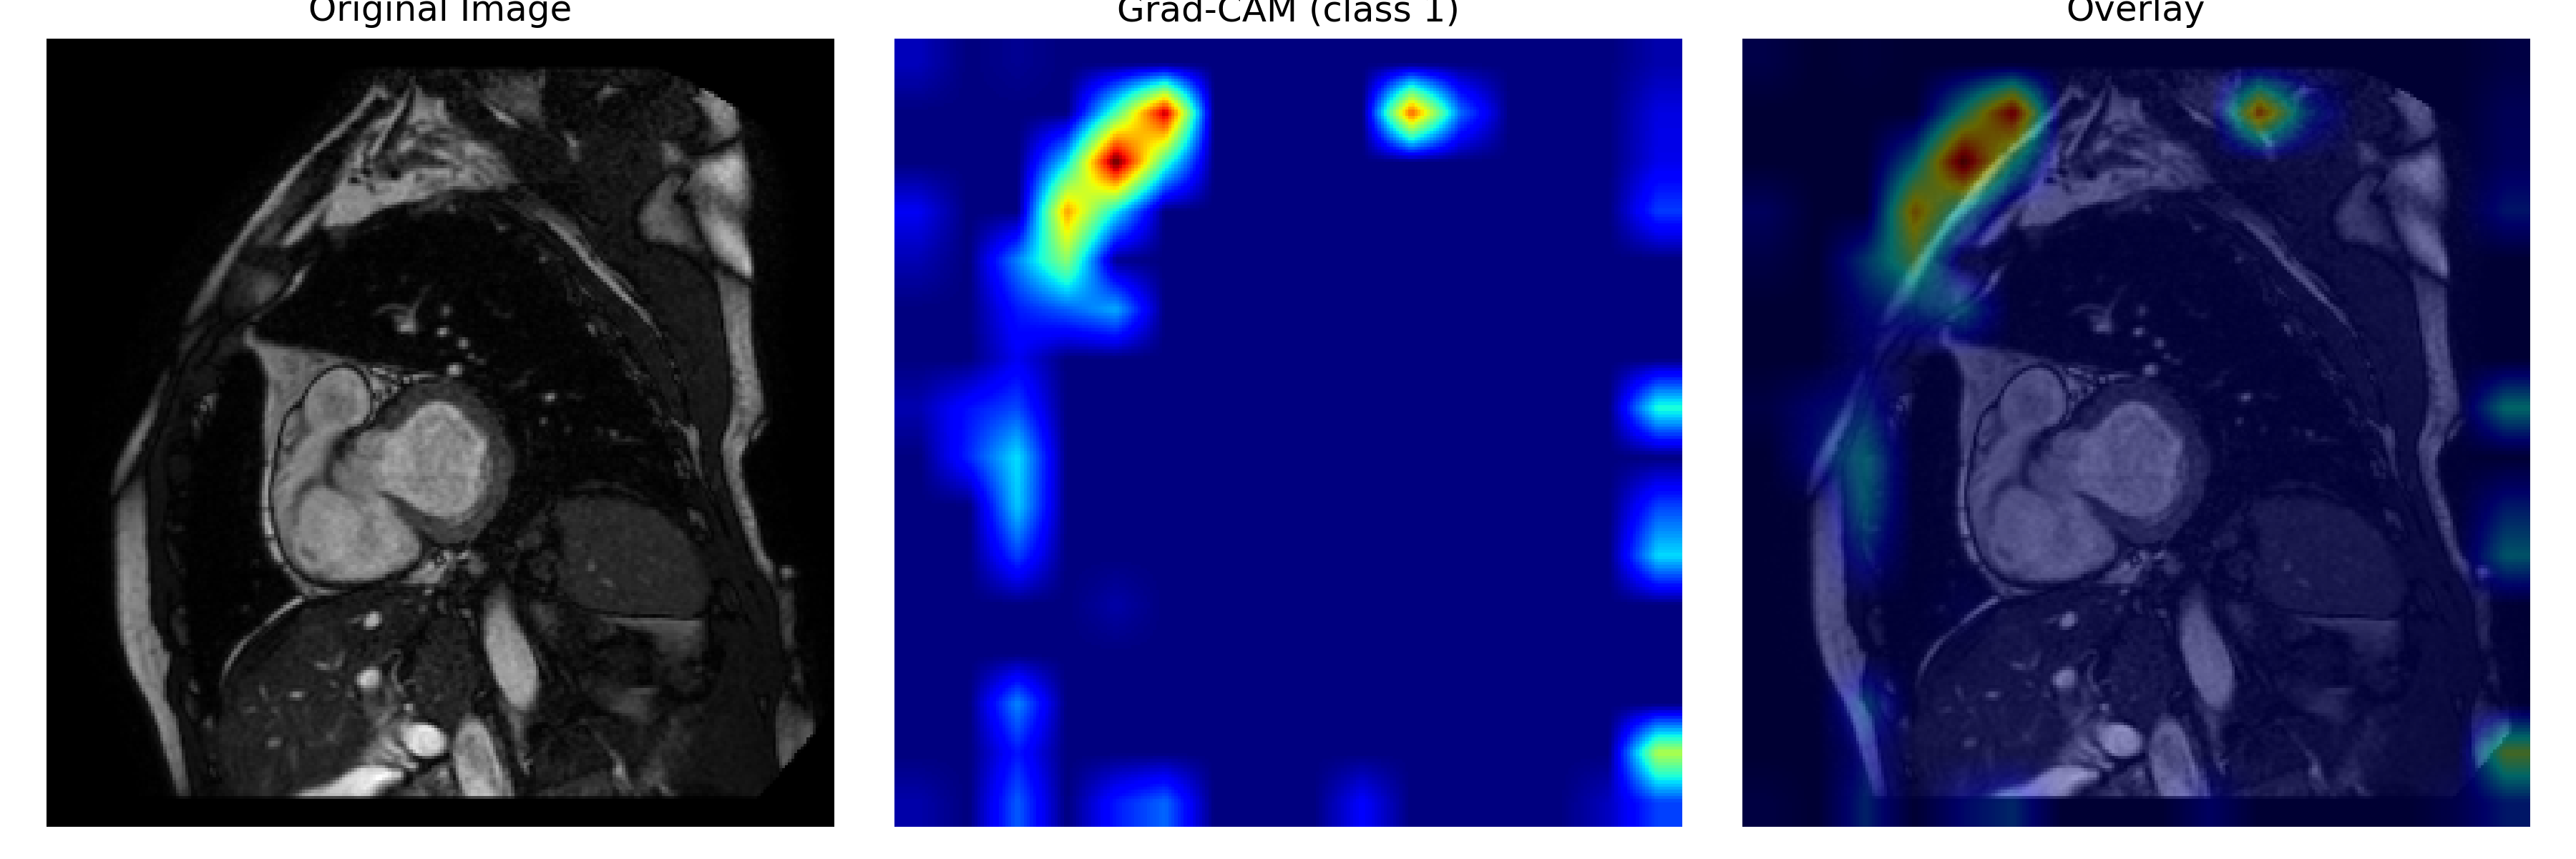

Grad-CAM for Epoch 30


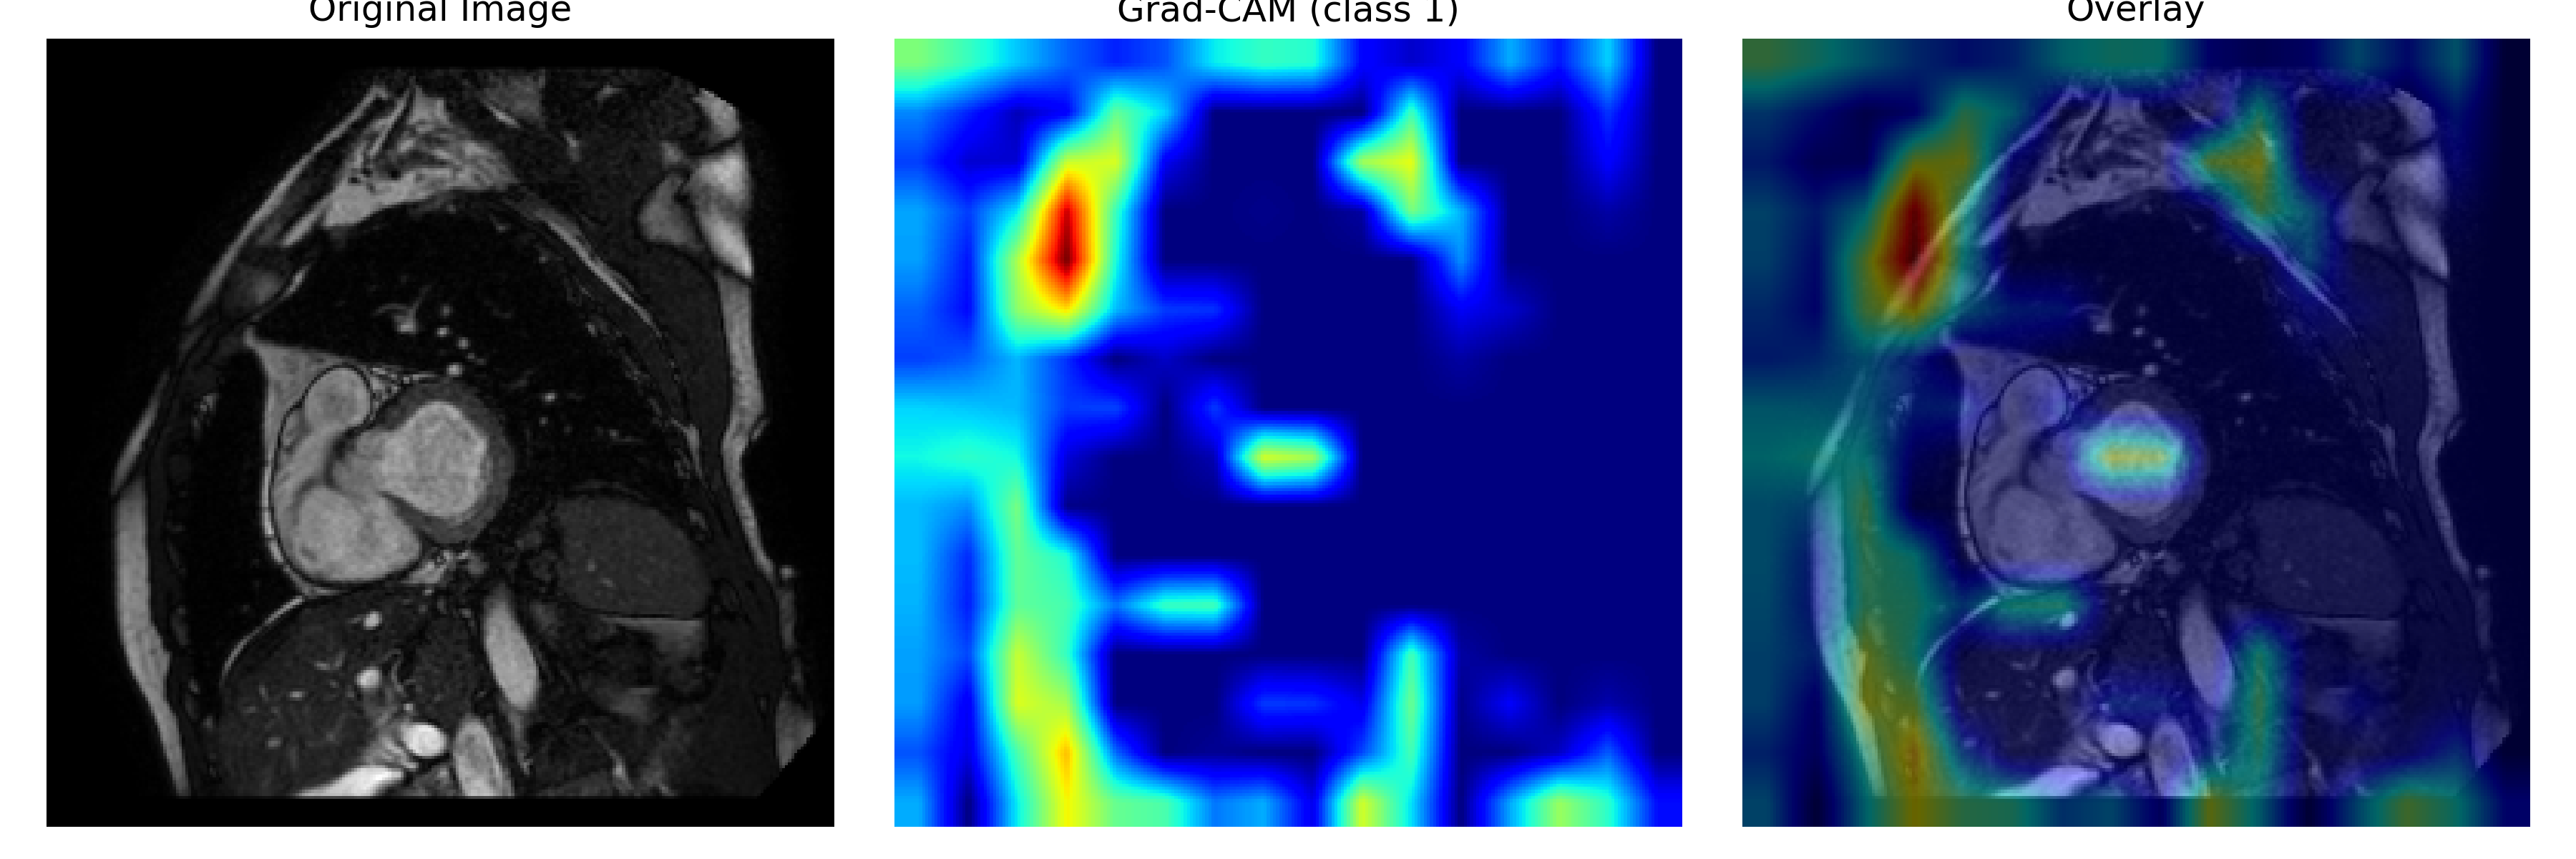

In [51]:
for epoch in [5, 10, 20, 25, 30]:
    path = os.path.join(PLOT_DIR, f"gradcam_epoch{epoch}.png")
    print(f"Grad-CAM for Epoch {epoch}")
    display(Image(filename=path))

### Use best_model.pth to make predictions on the validation set

In [31]:
# Load the model
model = UNet(in_channels=1, out_channels=3)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.load_state_dict(torch.load("best_model.pth", map_location=device))
model = model.to(device)
model.device = device
model.eval()

test_dataset = MnM2Dataset(DATA_DIR, val_ids, mode='ED')
test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=1, shuffle=False)

### Define evaluation function

In [40]:
def run_test_evaluation(model, test_loader, plot_dir, num_samples=5):
    model.eval()
    total_dice = 0
    total_iou = 0
    total = 0
    count = 0
    os.makedirs(plot_dir, exist_ok=True)

    with torch.no_grad():
        for batch in test_loader:
            images = batch['image'].to(model.device)
            masks = batch['mask'].to(model.device)
            outputs = model(images)

            # calculation indicators
            total_dice += dice_score(outputs, masks).item()
            total_iou += iou_score(outputs, masks).item()
            total += 1

            # save top num_samples prediction images
            preds = torch.argmax(outputs, dim=1)
            for i in range(images.shape[0]):
                if count >= num_samples:
                    break
                image = images[i][0].cpu().numpy()
                mask = masks[i].cpu().numpy()
                pred = preds[i].cpu().numpy()

                plt.figure(figsize=(12, 4))
                plt.subplot(1, 3, 1)
                plt.imshow(image, cmap='gray')
                plt.title("Image")
                plt.axis('off')

                plt.subplot(1, 3, 2)
                plt.imshow(mask, cmap='gray')
                plt.title("Ground Truth")
                plt.axis('off')

                plt.subplot(1, 3, 3)
                plt.imshow(pred, cmap='gray')
                plt.title("Prediction")
                plt.axis('off')

                plt.tight_layout()
                save_path = os.path.join(plot_dir, f"test_prediction_{count+1}.png")
                plt.savefig(save_path, dpi=300)
                plt.close()
                print(f"✅ Saved: {save_path}")
                count += 1

    avg_dice = total_dice / total
    avg_iou = total_iou / total

    return avg_dice, avg_iou, count

In [47]:
avg_dice, avg_iou, sample_count = run_test_evaluation(model, test_loader, PLOT_DIR, num_samples=10)

print(f"\n📊 Test Evaluation Summary:")
print(f"Average Dice Score: {avg_dice:.4f}")
print(f"Average IoU Score : {avg_iou:.4f}")
print(f"Saved {sample_count} prediction images to: {PLOT_DIR}")

✅ Saved: /Users/afra/Desktop/MRNetSegmentation/MnM2/plots/test_prediction_1.png
✅ Saved: /Users/afra/Desktop/MRNetSegmentation/MnM2/plots/test_prediction_2.png
✅ Saved: /Users/afra/Desktop/MRNetSegmentation/MnM2/plots/test_prediction_3.png
✅ Saved: /Users/afra/Desktop/MRNetSegmentation/MnM2/plots/test_prediction_4.png
✅ Saved: /Users/afra/Desktop/MRNetSegmentation/MnM2/plots/test_prediction_5.png
✅ Saved: /Users/afra/Desktop/MRNetSegmentation/MnM2/plots/test_prediction_6.png
✅ Saved: /Users/afra/Desktop/MRNetSegmentation/MnM2/plots/test_prediction_7.png
✅ Saved: /Users/afra/Desktop/MRNetSegmentation/MnM2/plots/test_prediction_8.png
✅ Saved: /Users/afra/Desktop/MRNetSegmentation/MnM2/plots/test_prediction_9.png
✅ Saved: /Users/afra/Desktop/MRNetSegmentation/MnM2/plots/test_prediction_10.png

📊 Test Evaluation Summary:
Average Dice Score: 0.9000
Average IoU Score : 0.8636
Saved 10 prediction images to: /Users/afra/Desktop/MRNetSegmentation/MnM2/plots


Prediction image - 2


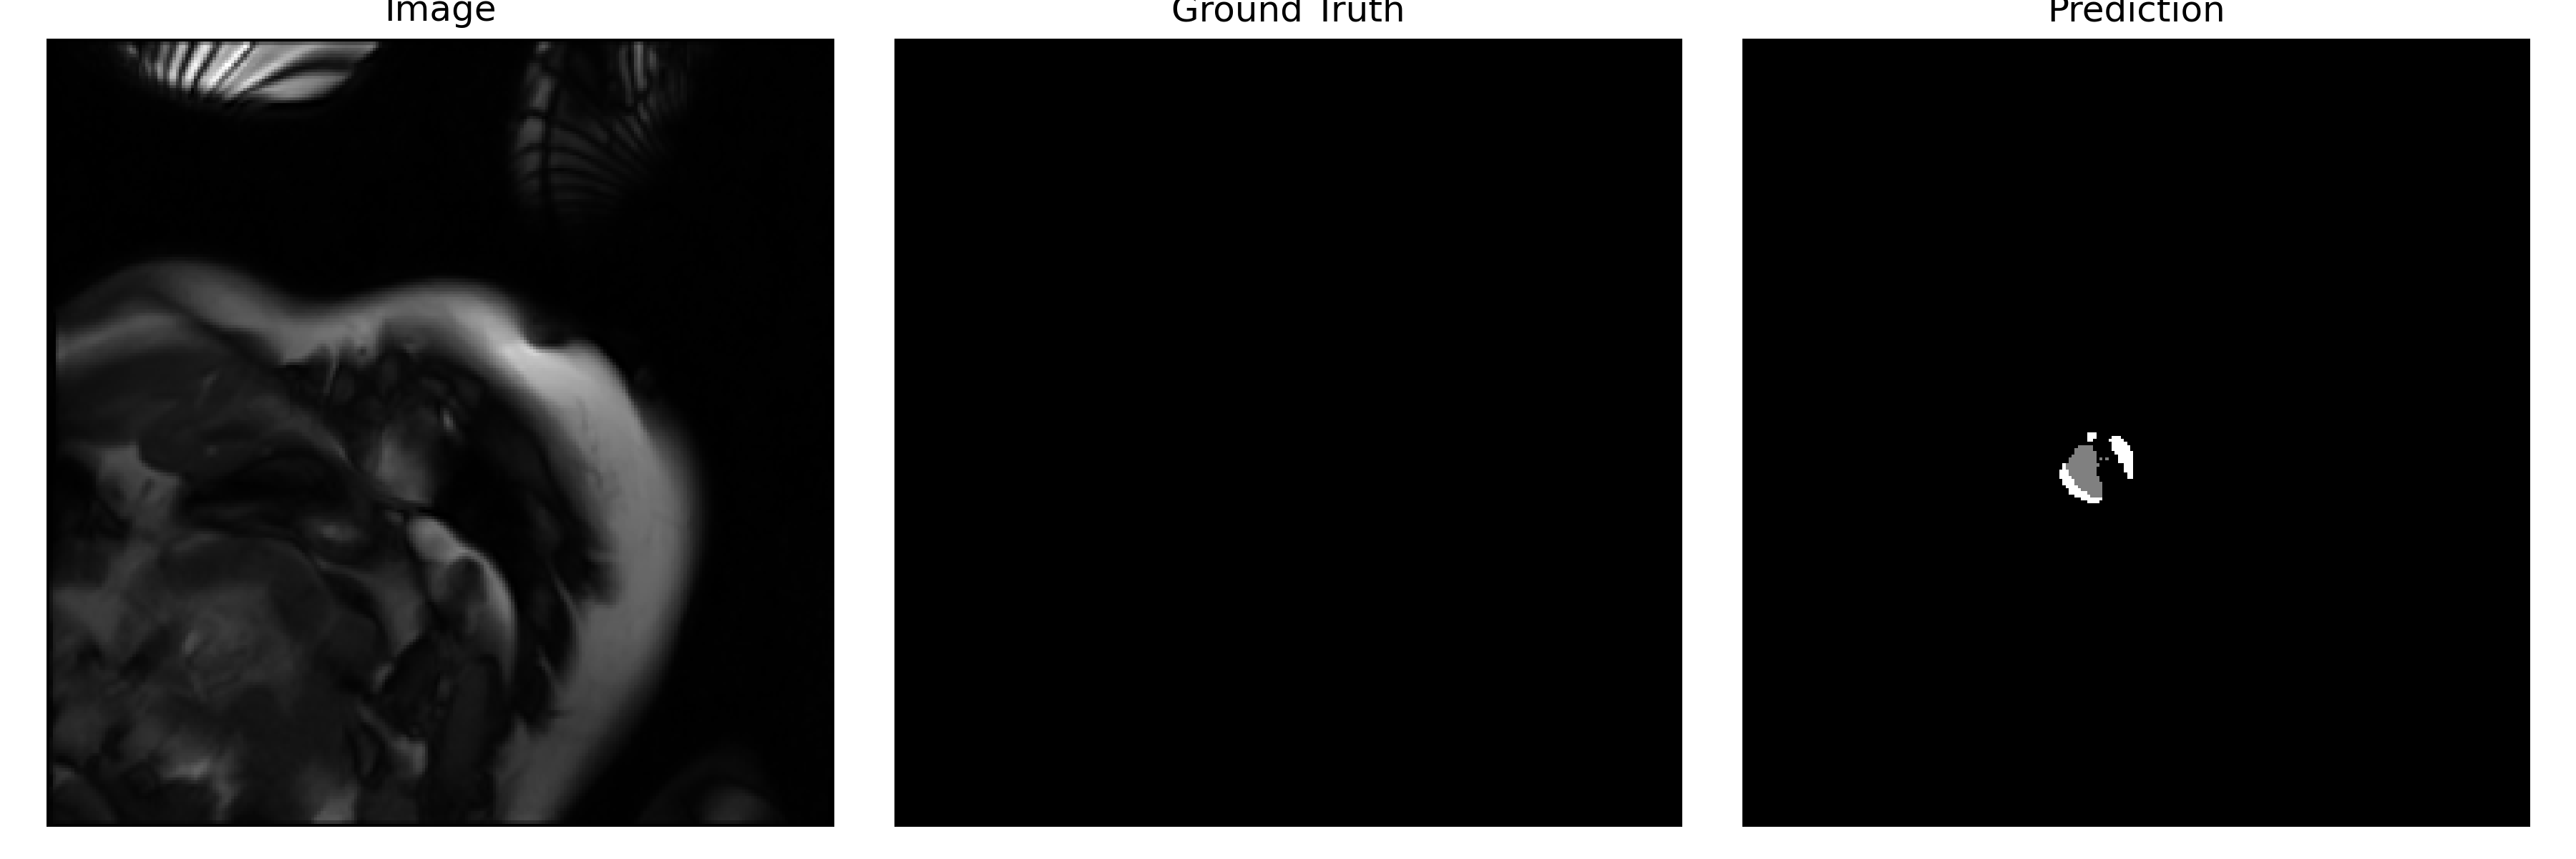

Prediction image - 4


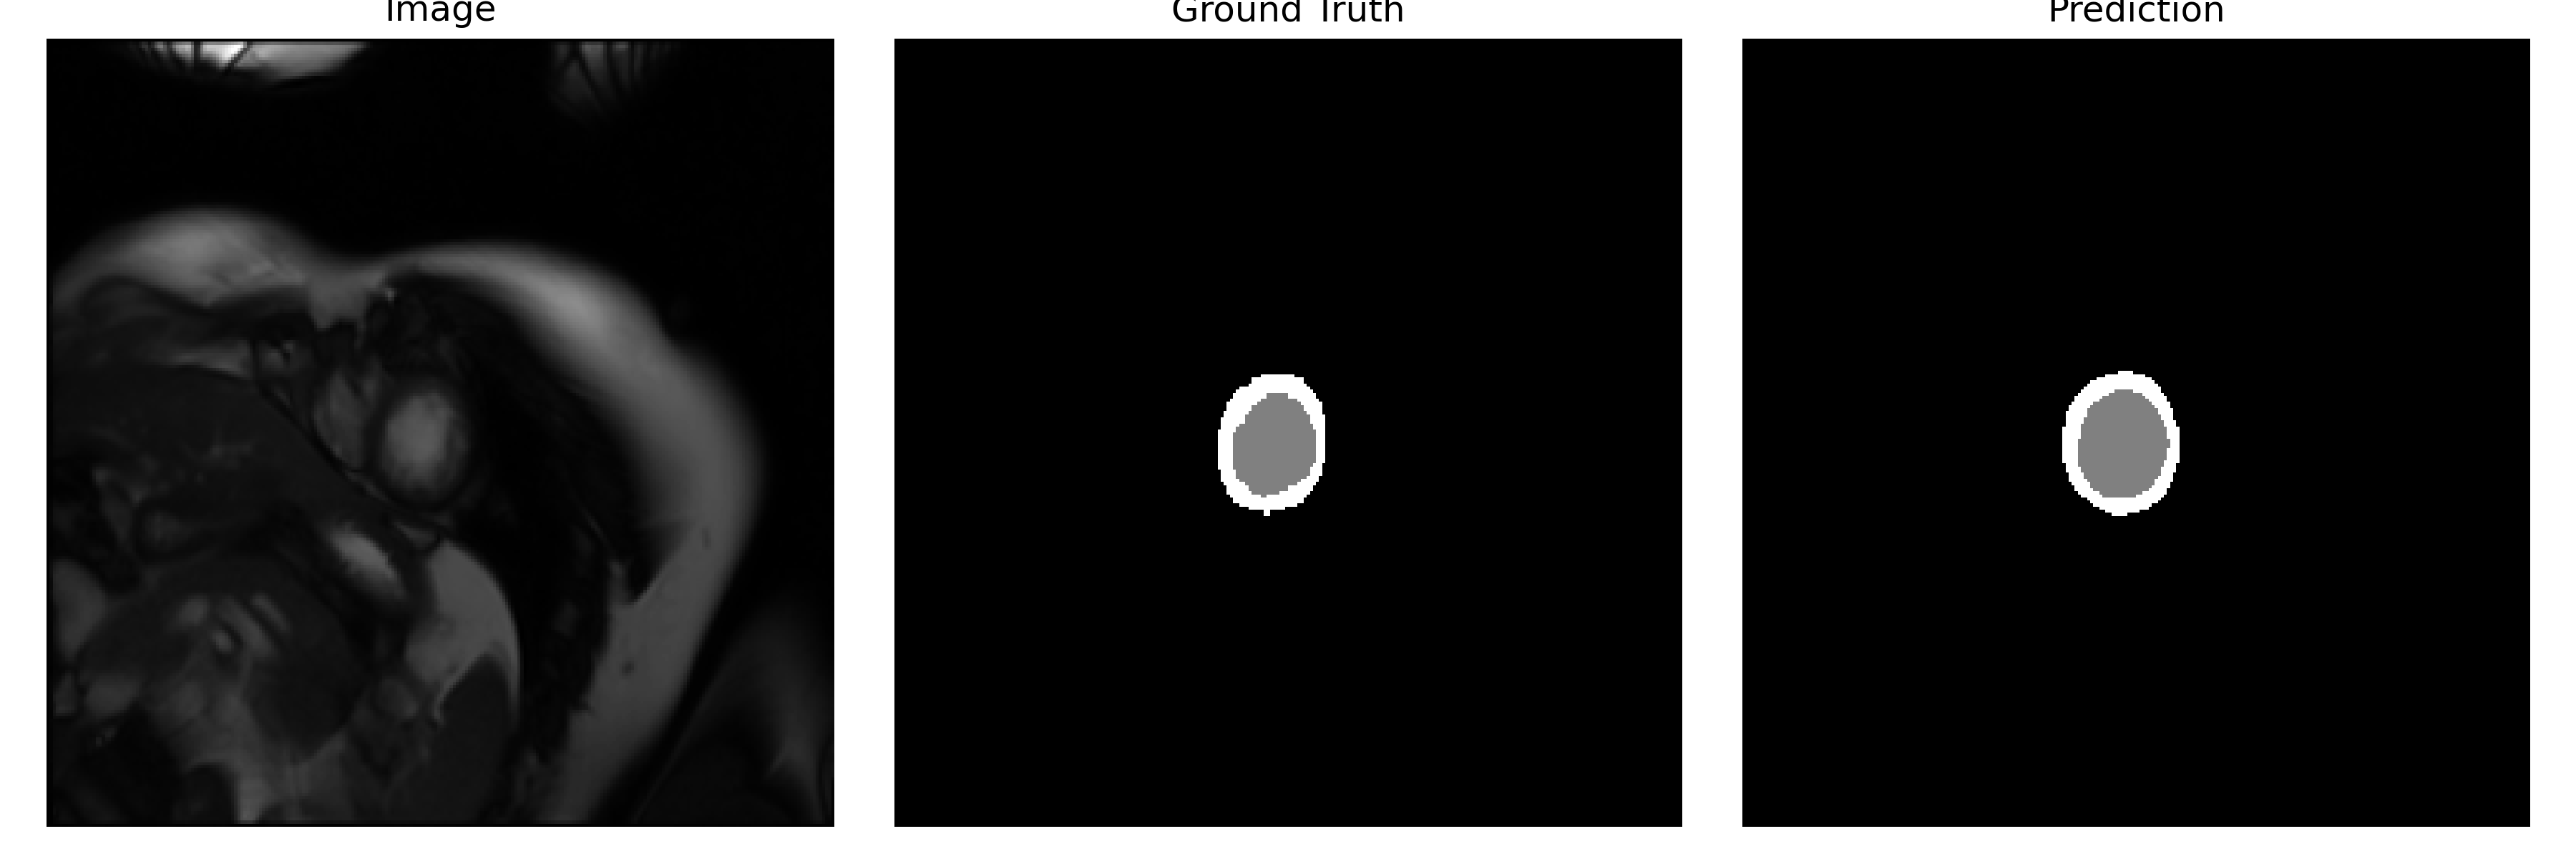

Prediction image - 6


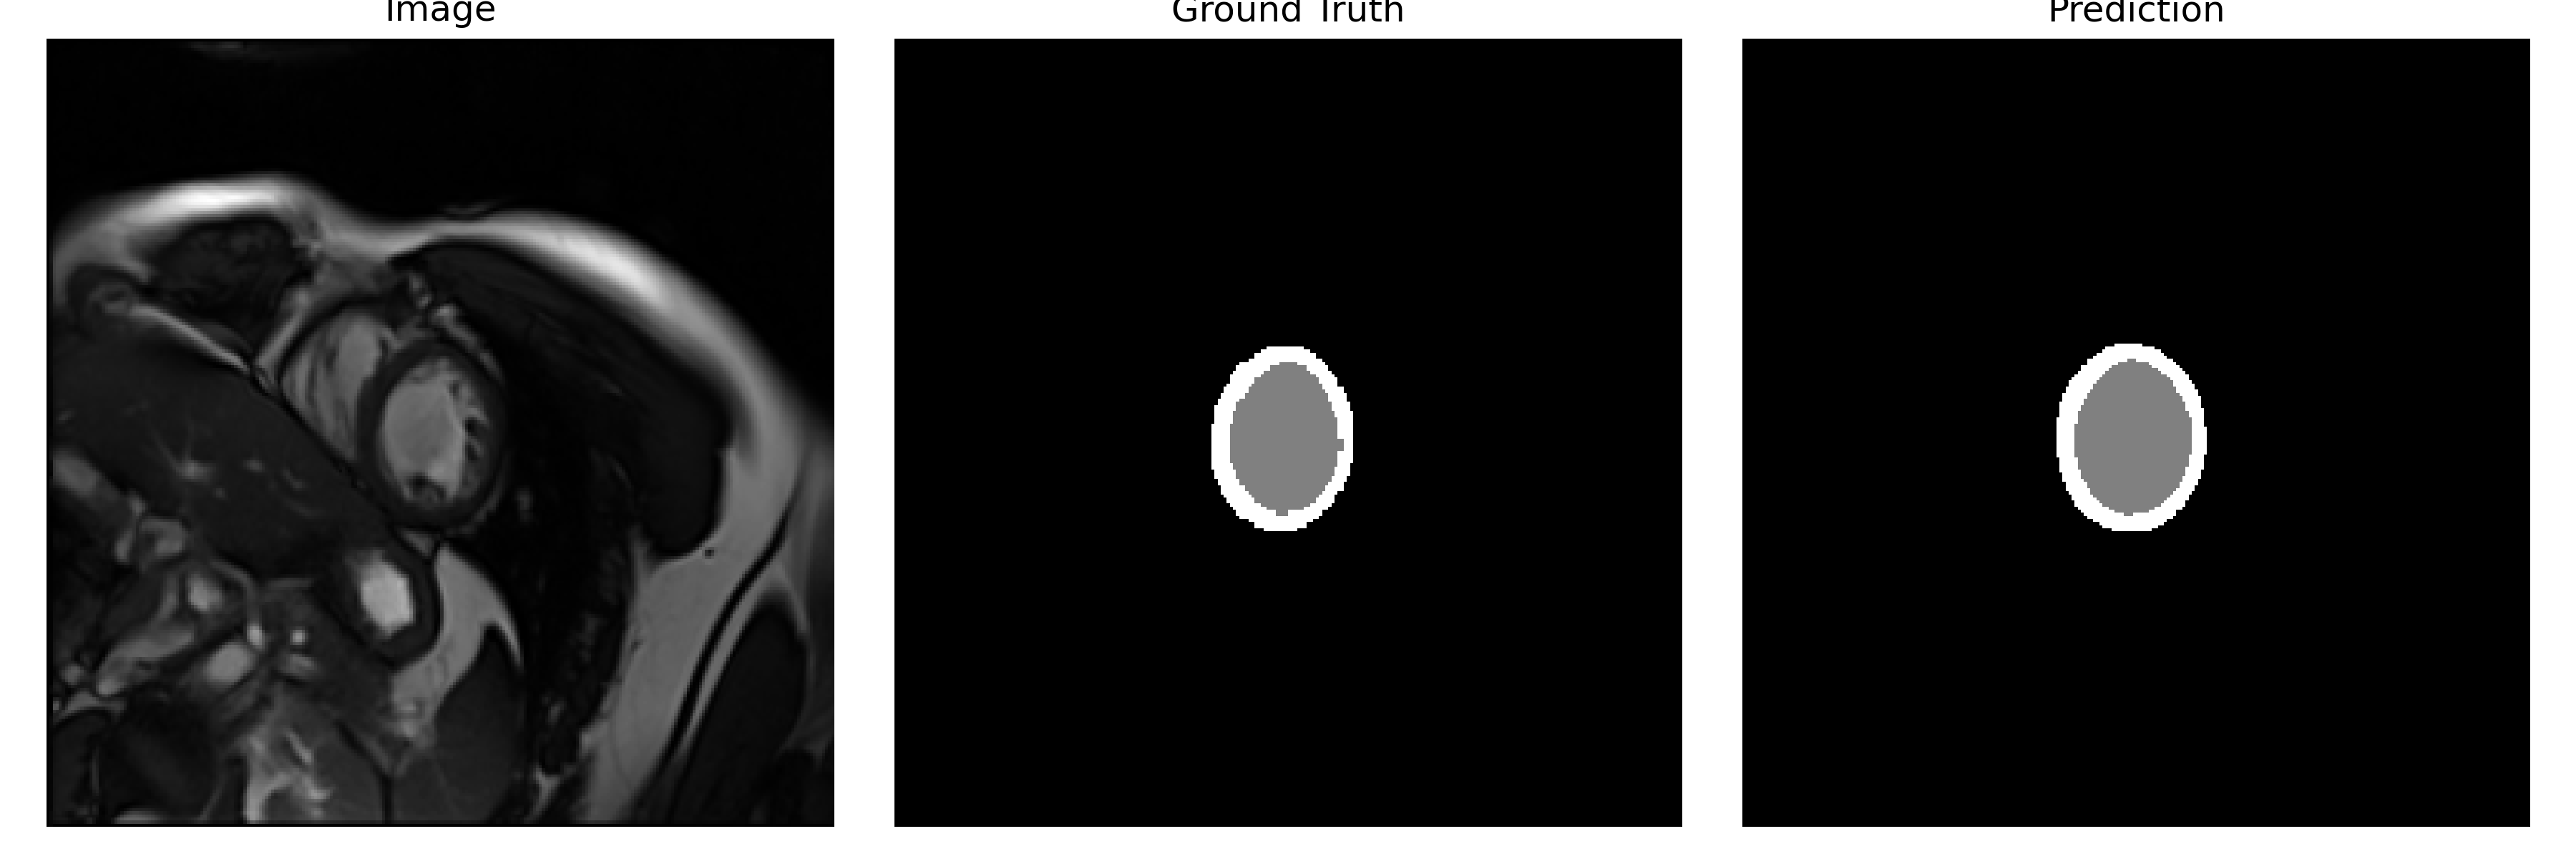

Prediction image - 8


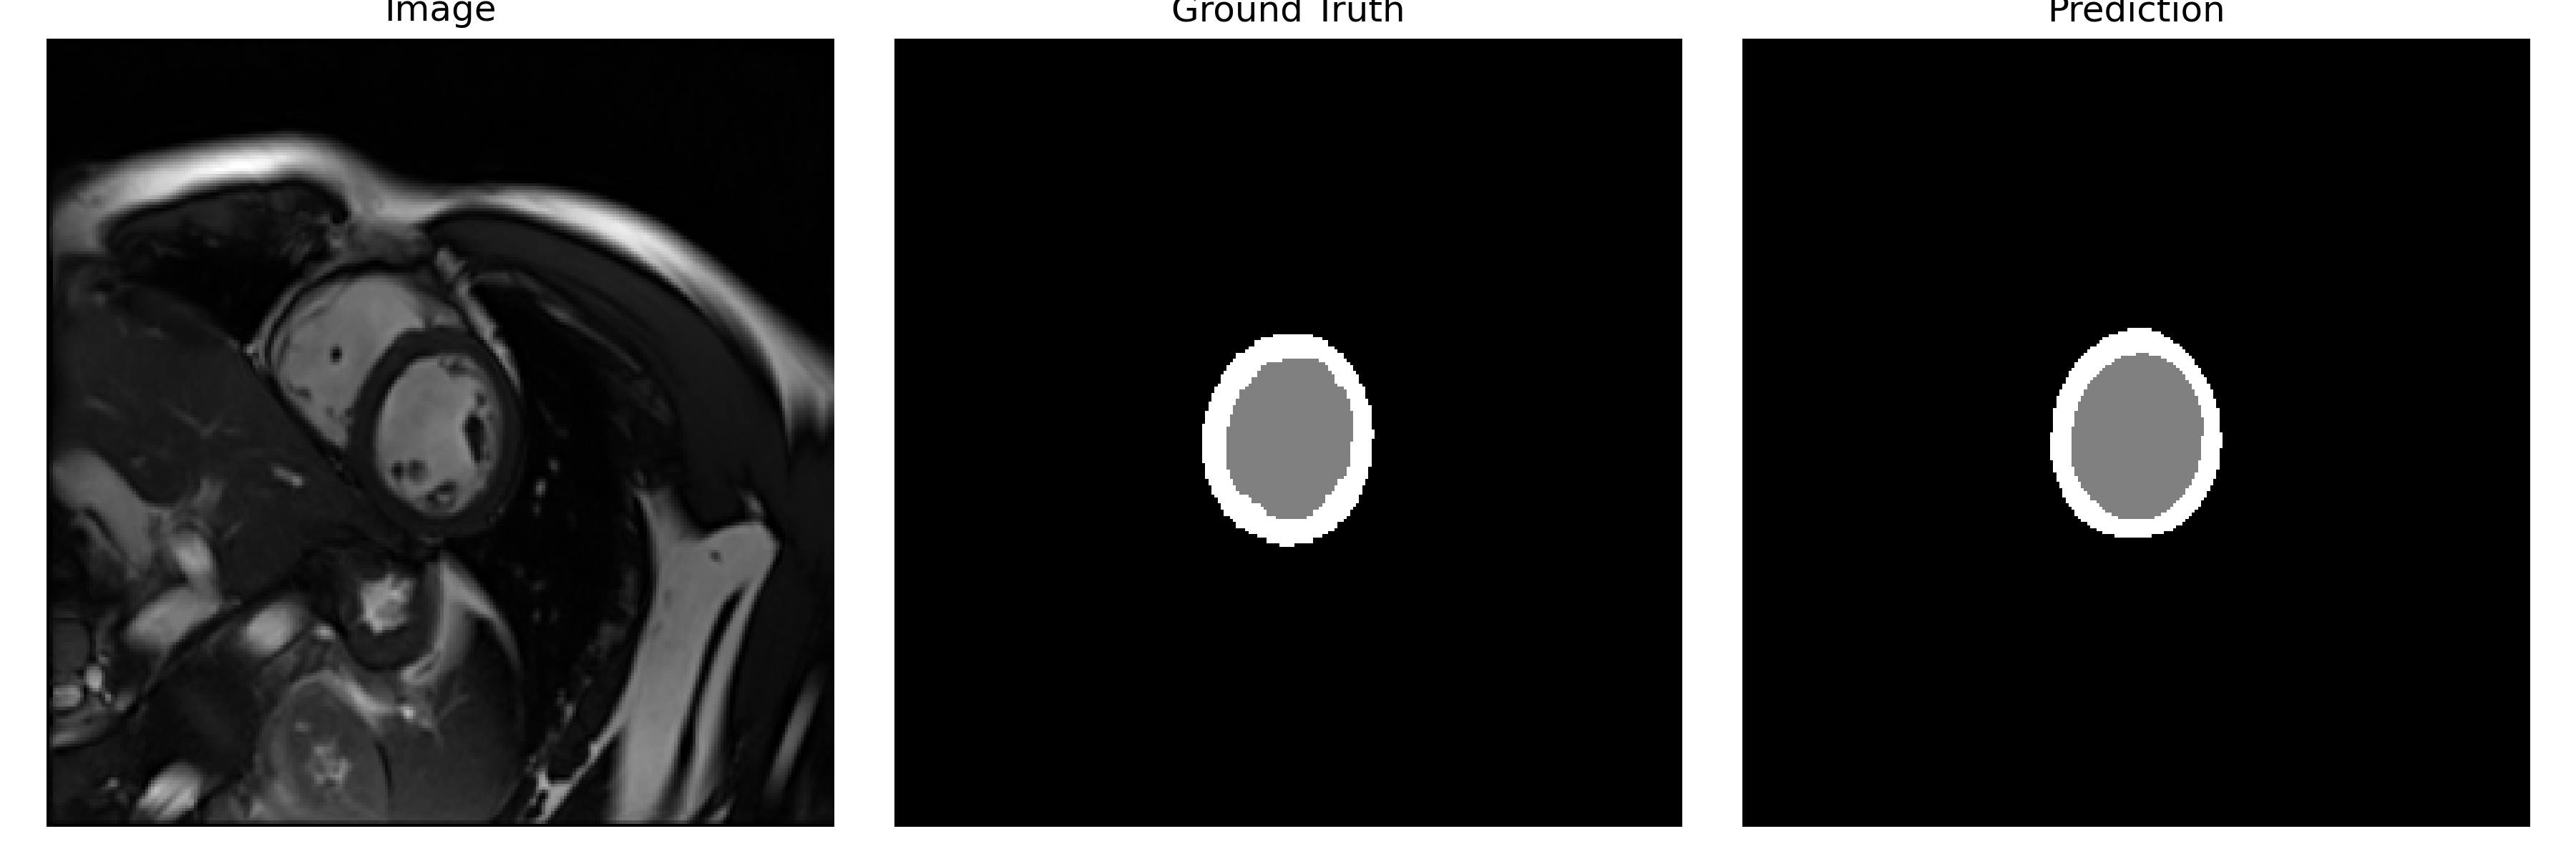

Prediction image - 10


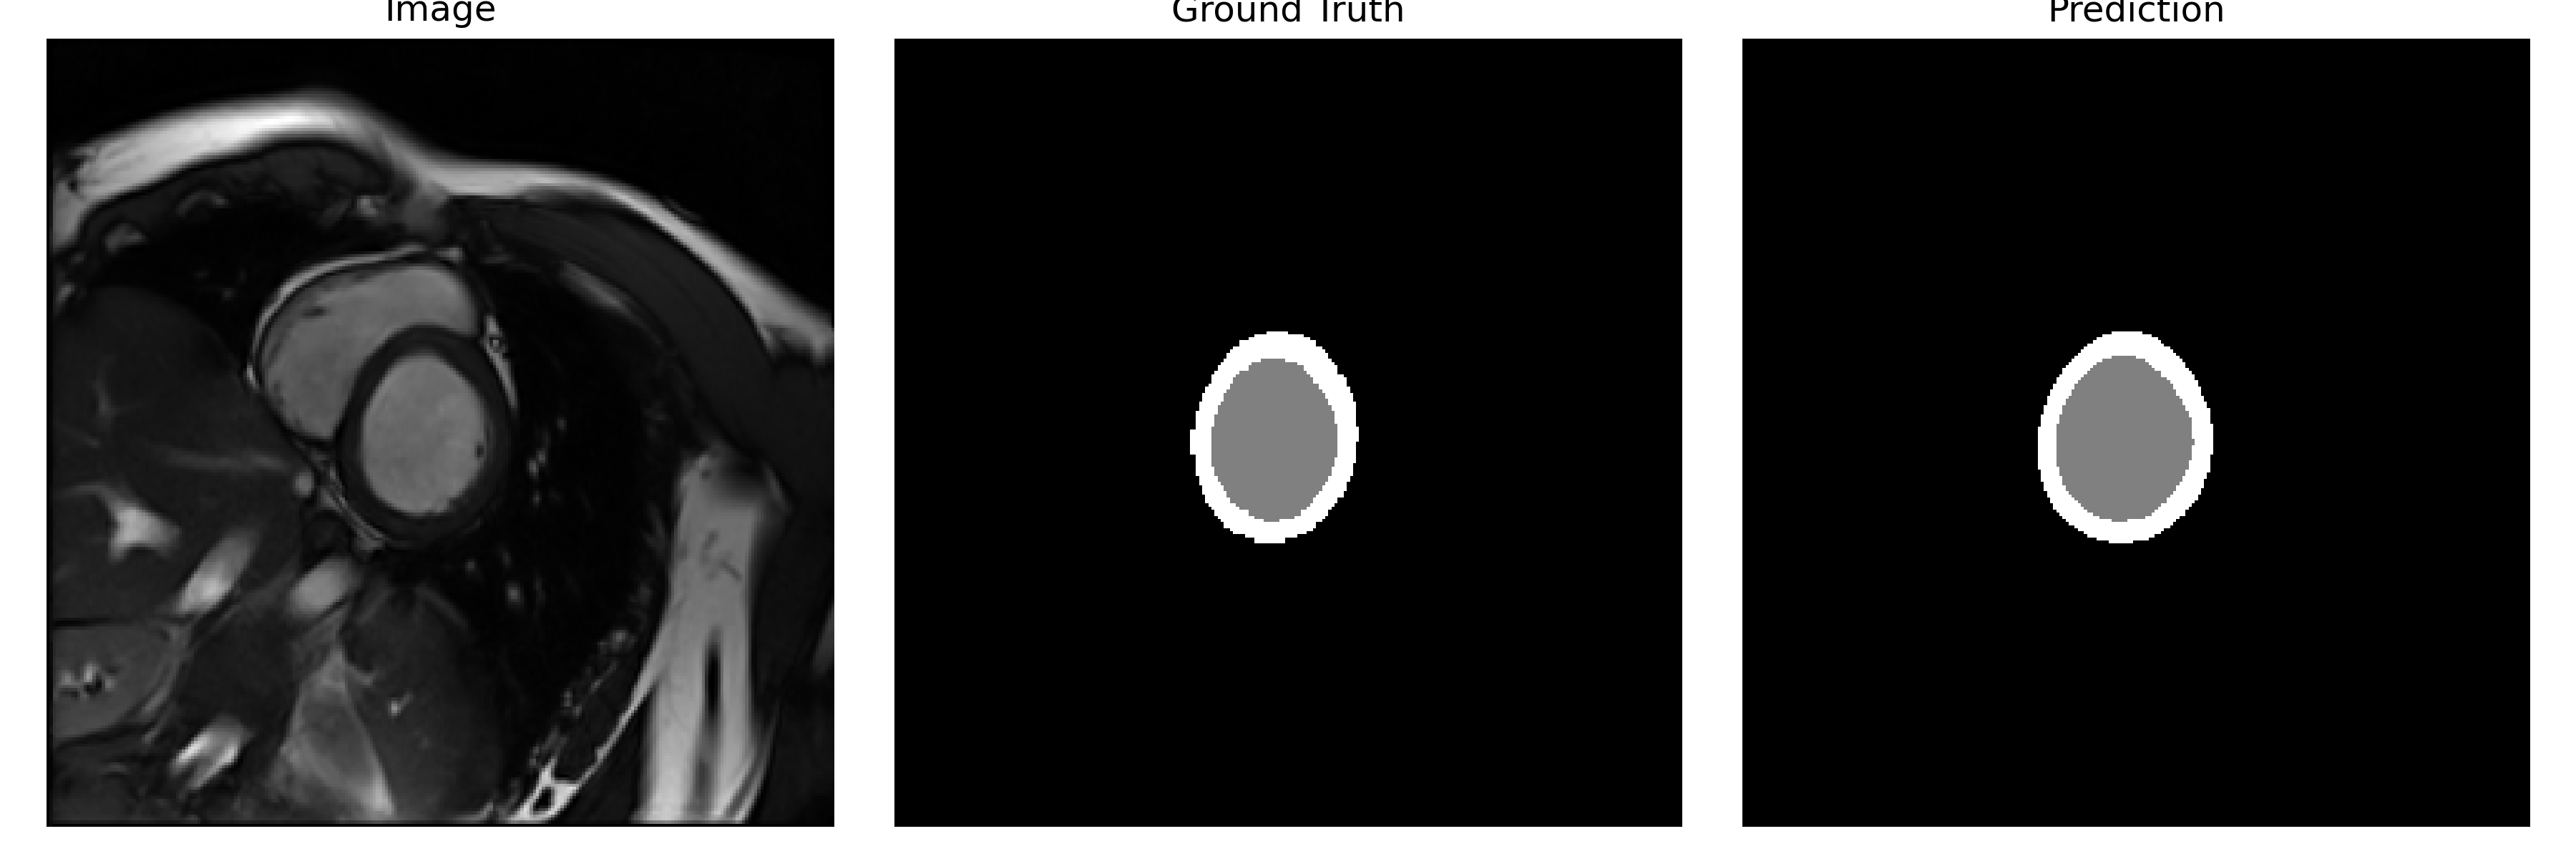

In [56]:
for count in [2, 4, 6, 8, 10]:
    path = os.path.join(PLOT_DIR, f"test_prediction_{count}.png")
    print(f"Prediction image - {count}")
    display(Image(filename=path))

In [33]:
import random
random.seed(2025)

def run_test_evaluation(model, test_loader, plot_dir, num_samples=5):
    """
    Evaluate model on the test set and randomly visualize sample predictions.

    Args:
        model: Trained segmentation model.
        test_loader: DataLoader for test set.
        plot_dir: Directory to save prediction plots.
        num_samples: Number of test samples to visualize (randomly selected).

    Returns:
        avg_dice: Average Dice score across test set.
        avg_iou: Average IoU score across test set.
        count: Number of samples visualized.
    """
    model.eval()
    os.makedirs(plot_dir, exist_ok=True)

    # Store all images, ground truths, and predictions
    all_images = []
    all_masks = []
    all_preds = []

    total_dice = 0
    total_iou = 0
    total = 0

    with torch.no_grad():
        for batch in test_loader:
            images = batch['image'].to(model.device)
            masks = batch['mask'].to(model.device)
            outputs = model(images)

            # Accumulate Dice and IoU for the full test set
            total_dice += dice_score(outputs, masks).item()
            total_iou += iou_score(outputs, masks).item()
            total += 1

            # Get predictions (argmax over class channel)
            preds = torch.argmax(outputs, dim=1)

            # Move tensors to CPU and store for later visualization
            all_images.extend(images.cpu())
            all_masks.extend(masks.cpu())
            all_preds.extend(preds.cpu())

    # Compute average metrics
    avg_dice = total_dice / total
    avg_iou = total_iou / total

    # Randomly select N samples for visualization
    indices = random.sample(range(len(all_images)), min(num_samples, len(all_images)))

    for count, i in enumerate(indices):
        image = all_images[i][0].numpy()
        mask = all_masks[i].numpy()
        pred = all_preds[i].numpy()

        # Plot image, ground truth, and prediction
        plt.figure(figsize=(12, 4))
        plt.subplot(1, 3, 1)
        plt.imshow(image, cmap='gray')
        plt.title("Image")
        plt.axis('off')

        plt.subplot(1, 3, 2)
        plt.imshow(mask, cmap='gray')
        plt.title("Ground Truth")
        plt.axis('off')

        plt.subplot(1, 3, 3)
        plt.imshow(pred, cmap='gray')
        plt.title("Prediction")
        plt.axis('off')

        plt.tight_layout()
        save_path = os.path.join(plot_dir, f"test_prediction_{count+1}.png")
        plt.savefig(save_path, dpi=300)
        plt.close()
        print(f"✅ Saved: {save_path}")

    return avg_dice, avg_iou, len(indices)

In [35]:
avg_dice, avg_iou, sample_count = run_test_evaluation(model, test_loader, PLOT_DIR, num_samples=10)

print(f"\n📊 Test Evaluation Summary:")
print(f"Average Dice Score: {avg_dice:.4f}")
print(f"Average IoU Score : {avg_iou:.4f}")
print(f"Saved {sample_count} prediction images to: {PLOT_DIR}")

✅ Saved: /Users/afra/Desktop/MRNetSegmentation/MnM2/plots/test_prediction_1.png
✅ Saved: /Users/afra/Desktop/MRNetSegmentation/MnM2/plots/test_prediction_2.png
✅ Saved: /Users/afra/Desktop/MRNetSegmentation/MnM2/plots/test_prediction_3.png
✅ Saved: /Users/afra/Desktop/MRNetSegmentation/MnM2/plots/test_prediction_4.png
✅ Saved: /Users/afra/Desktop/MRNetSegmentation/MnM2/plots/test_prediction_5.png
✅ Saved: /Users/afra/Desktop/MRNetSegmentation/MnM2/plots/test_prediction_6.png
✅ Saved: /Users/afra/Desktop/MRNetSegmentation/MnM2/plots/test_prediction_7.png
✅ Saved: /Users/afra/Desktop/MRNetSegmentation/MnM2/plots/test_prediction_8.png
✅ Saved: /Users/afra/Desktop/MRNetSegmentation/MnM2/plots/test_prediction_9.png
✅ Saved: /Users/afra/Desktop/MRNetSegmentation/MnM2/plots/test_prediction_10.png

📊 Test Evaluation Summary:
Average Dice Score: 0.9000
Average IoU Score : 0.8636
Saved 10 prediction images to: /Users/afra/Desktop/MRNetSegmentation/MnM2/plots
